# Dfsu - 2D interpolation
This notebook demonstrates how to interpolate dfsu data to a grid, how to save the gridded data as dfs2 and geotiff. It also shows how to interpolate dfsu data to another mesh. 

In [1]:
import mikeio

In [2]:
ds = mikeio.read("../tests/testdata/wind_north_sea.dfsu", items="Wind speed")
ds

<mikeio.Dataset>
Geometry: Dfsu2D
Dimensions: (time:6, element:958)
Time: 2017-10-27 00:00:00 - 2017-10-27 05:00:00 (6 records)
Items:
  0:  Wind speed <Wind speed> (meter per sec)

In [3]:
da = ds.Wind_speed

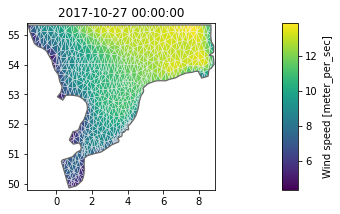

In [4]:
da.plot();

## Interpolate to grid
1. Get an overset grid covering the domain
2. Then interpolate all data to the new grid and plot. 
4. The interpolated data is then saved to a dfs2 file.

In [18]:
g = da.geometry.get_overset_grid(dx=0.1)
g

<mikeio.Grid2D>
x-axis: nx=105 points from x0=-1.52855 to x1=8.87145 with dx=0.1
y-axis: ny=55 points from y0=49.9227 to y1=55.3227 with dy=0.1
Number of grid points: 5775

In [19]:
da_grid = da.interp(g)
da_grid

<mikeio.DataArray>
Name: Wind speed
Dimensions: (time:6, y:55, x:105)
Time: 2017-10-27 00:00:00 - 2017-10-27 05:00:00 (6 records)

<AxesSubplot:xlabel='Longitude [degrees]', ylabel='Latitude [degrees]'>

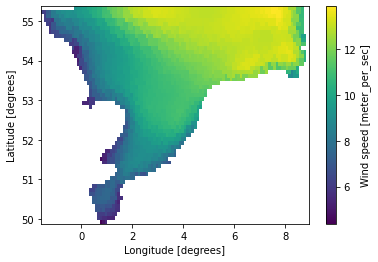

In [20]:
da_grid.plot()

## Save to dfs2 file

In [21]:
da_grid.to_dfs("wind_north_sea_interpolated.dfs2")

![](../images/dfsu_grid_interp.png)

## Save to NetCDF

In [22]:
xr_da = da_grid.to_xarray()
xr_da.to_netcdf("wind_north_sea_interpolated.nc")

![](../images/dfsu_grid_netcdf.png)

## Save to GeoTiff

Install [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) by running this in a command prompt before running this notebook

`conda install -c conda-forge rasterio`

Or if you prefer to avoid conda, here is how:
https://rasterio.readthedocs.io/en/latest/installation.html#windows

In [23]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
# Dcoumentation https://rasterio.readthedocs.io/en/latest/index.html

with rasterio.open(
     'wind.tif',
     'w',
     driver='GTiff',
     height=g.ny,
     width=g.nx,
     count=1,
     dtype=da.dtype,
     crs='+proj=latlong',
     transform=from_origin(g.bbox.left, g.bbox.top, g.dx, g.dy)
     ) as dst:
        dst.write(np.flipud(da_grid[0].to_numpy()), 1) # first time_step
    

![](../images/dfsu_grid_interp_tiff.png)

# Interpolate to other mesh
Interpolate the data from this coarse mesh onto a finer resolution mesh


In [ ]:
msh = Mesh('../tests/testdata/north_sea_2.mesh')

In [ ]:
dfs.n_elements, msh.n_elements  # new mesh has more elements

In [ ]:
xy = msh.element_coordinates[:,:2]
interpolant = dfs.get_2d_interpolant(xy, n_nearest=4)

In [ ]:
dsi = dfs.interp2d(ds, *interpolant)

In [ ]:
dat_orig = ds[0][0,:]
dfs.plot(dat_orig, figsize=(9,7));

In [ ]:
dat_interp = dsi[0][0,:]
msh.plot(dat_interp, figsize=(9,7));

### Note: 3 of the new elements are outside the original mesh and data are therefore NaN by default

In [ ]:
nan_elements = msh.element_ids[np.isnan(dat_interp.to_numpy())]
nan_elements

In [ ]:
dfs.contains(msh.element_coordinates[nan_elements,:2])

### We can force extrapolation to avoid the NaN values

In [ ]:
interpolant = dfs.get_2d_interpolant(xy, n_nearest=4, extrapolate=True)
dat_interp = dfs.interp2d(dat_orig.to_numpy(), *interpolant)

In [ ]:
n_nan_elements = sum(np.isnan(dat_interp))
n_nan_elements

## Interpolate scatter data to mesh

We want to interpolate scatter data onto an existing mesh and create a new dfsu with the interpolated data. 

In [ ]:
from mikeio.spatial import dist_in_meters
from mikeio.interpolation import get_idw_interpolant

In [ ]:
dfs = Dfsu('../tests/testdata/wind_north_sea.dfsu')

In [ ]:
dfs.plot(plot_type="mesh_only");

In [ ]:
# scatter data: x,y,value for 4 points
scatter= np.array([[1,50,1], [4, 52, 3], [8, 55, 2], [-1, 55, 1.5]])
scatter

Let's first try the approx for a single element: 

* calc distance to all interpolation points
* calc IDW interpolatant weights
* Interpolate

In [ ]:
dist = dist_in_meters(scatter[:,:2], dfs.element_coordinates[0,:2])
dist

In [ ]:
w = get_idw_interpolant(dist, p=2)
w

In [ ]:
np.dot(scatter[:,2], w) # interpolated value in element 0

Let's do the same for all points in the mesh and plot in the end

In [ ]:
dati = np.zeros((1,dfs.n_elements))
for j in range(dfs.n_elements):
    dist = dist_in_meters(scatter[:,:2], dfs.element_coordinates[j,:2])
    w = get_idw_interpolant(dist, p=2)
    dati[0,j] = np.dot(scatter[:,2], w)

In [ ]:
dfs.plot(dati, title="Interpolated scatter data");

In [ ]:
dfs.write("interpolated_scatter.dfsu", [dati], start_time=dfs.start_time)

## Clean up

In [ ]:
import os

os.remove("wind_north_sea_interpolated.dfs2")
os.remove("gridmesh.mesh")
os.remove("wind.tif")
os.remove("interpolated_scatter.dfsu")